# Bonds and clusters

## Importing packages

In [1]:
# Importing necessary packages:
from glob import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
dmon_l_c_pal = ['orange', 'darkgoldenrod', 'forestgreen']

# TransFoci

## Per geometry:

In [ ]:
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
#hist_names = dict(zip(hist_properties, ['clusters', 'bonds']))
measures = ['mean', 'sem', 'var']
species = 'Foci'
bin_center_labels = {
   'clustersHistFoci': '$x_c$',
   'bondsHistFoci': '$x_d$'
}
phase = 'ensAvg'
foci = []
# Project details
#project = 'HnsCub'
#project = 'TransFociCyl'
#project = 'SumRuleCyl'
project = 'TransFociCub'
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
for prop in hist_properties:
    cols_to_drop = [prop + '-' + measure for measure in  measures]
    AL['bin_center'] = bin_center_labels[prop]
    hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
    hist_df = allInOne_db + hist_df
    hist_df = pd.read_parquet(hist_df)
    hist_df.drop(columns=cols_to_drop, inplace=True)
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    #hist_df.reset_index(inplace=True, drop=True)
    hist_df['property'] = prop
    hist_df.rename(columns={prop + '-norm': 'value'}, inplace=True)
    foci.append(hist_df)
foci =  pd.concat(foci, axis=0)
# a sorted list of unique spaces in the dataset
spaces = hist_df['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_title_style = ''
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project == 'TransFociCub':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'TransFociCyl':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'SumRuleCyl':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$D={s_info.dcyl},$ " +
                             fr"$a_c={s_info.dcrowd}$")
    elif project == 'HnsCub':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$N_{{hns}}={s_info.nhns},$ " +
                             fr"a_c={s_info.dcrowd}$")
    else:
        raise ValueError(f"Project: '{project}' is not defined.")

### per property:

In [ ]:
## plotting
height = 4
aspect = 1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}

plot_details = {
    'TransFociCyl': [
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ],
    'TransFociCub': [
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.8), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.73), 3)
    ]
}

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0, 0.2, 0.3, 0.4]))
prop_name = 'clustersHistFoci'
property_cond = (foci['property'].isin([prop_name]))
conds = phi_c_bulk_cond & property_cond
for (title_style, col_attr, hue_attr, t_x, t_y, c_pal, leg_anch, ncol) in plot_details[project]:
    
    foci_filtered = foci.loc[conds,:]
    foci_filtered.reset_index(drop=True, inplace=True)
    data = foci_filtered
    nmon_large = data['nmon_large'].unique()[0]
    color_palette = c_pal
    sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
    x_prop = 'bin_center'
    y_prop = 'value'
    col_order = sorted(data[col_attr].unique())
    col_wrap = 2
    hue_order = sorted(data[hue_attr].unique())
    f_grid = sns.catplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        col_wrap=col_wrap,
        hue=hue_attr,
        hue_order=hue_order,
        height=height,
        aspect=aspect,
        palette=color_palette,
        legend='full',
        sharey=False,
        sharex=False,
        kind='point',
        dodge=0.07
    )
    f_grid.set_titles("")
    xlims = {
        'bondsHistFoci': [0, nmon_large-1],
        'clustersHistFoci': [1, nmon_large]
    }
    f_grid.set_ylabels(AL[prop_name+'-norm-full_name'])
    f_grid.set_xlabels(bin_center_labels[prop_name])
    for idx, (ax, col_name) in enumerate(zip(f_grid.axes.flat,col_order)):
        ax.text(t_x, t_y, AL[col_attr] + fr"$={col_name}$",
                color='black',
                ha="center",
                va="center",
                bbox=global_bbox,
                transform=ax.transAxes)
    f_grid.set(yticks=np.arange(0,1.2,0.2))
    if title_style == 'talk':
            f_grid.fig.suptitle(project_title_style, **fig_title_kws)
    sns.move_legend(
        f_grid,
        title=AL[hue_attr],
        loc='upper left',
        bbox_to_anchor=leg_anch,
        ncol=ncol,
        **legend_kws
    )
    f_grid.tight_layout(w_pad=0.2, h_pad=0.1)
    output = "-".join(['Clustering', title_style, col_attr,
                       hue_attr,PD[project]['geometry_name'],
                       PD[project]['chain_name']])
    f_grid.savefig(
        save_to + output + '.' + ext, bbox_inches='tight', dpi=300
    )
    plt.close()

### property per col

In [ ]:

## plotting
height = 2.5
aspect = 1.5 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}
#foci_filtered = foci#.loc[conds,:]
#foci_filtered.reset_index(drop=True, inplace=True)
plot_details = {
    'TransFociCyl': [
        ('paper', 'dmon_large', 'phi_c_bulk_round', 0.67,0.8, 'viridis', (0.81,0.9), 1),
        ('talk', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ],
    'TransFociCub': [
        ('paper', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('talk', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ]
}

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
conds = phi_c_bulk_cond
for (title_style, row_attr, hue_attr, t_x, t_y, c_pal, leg_anch, ncol) in plot_details[project]:
    if row_attr == 'phi_c_bulk_round':
        foci_filtered = foci.loc[conds,:]
        foci_filtered.reset_index(drop=True, inplace=True)
        data = foci_filtered
    else:
        data = foci
    nmon_large = data['nmon_large'].unique()[0]
    color_palette = c_pal
    sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
    x_prop = 'bin_center'
    y_prop = 'value'
    col_attr = 'property'
    col_order = sorted(data[col_attr].unique())
    row_order = sorted(data[row_attr].unique())
    hue_order = sorted(data[hue_attr].unique())
    f_grid = sns.catplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        height=height,
        aspect=aspect,
        palette=color_palette,
        legend='full',
        sharey=False,
        sharex=False,
        kind='point',
        dodge=0.05
    )
    f_grid.set_titles("")
    row_col_pairs = list(itertools.product(row_order,col_order))
    xlims = {
        'bondsHistFoci': [0, nmon_large-1],
        'clustersHistFoci': [1, nmon_large]
    }
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.set_ylabel(AL[col_name+'-norm'])
        ax.text(t_x, t_y, AL[row_attr] + fr"$={row_name}$",
                color='black',
                ha="center",
                va="center",
                bbox=global_bbox,
                transform=ax.transAxes)
        if idx >= (len(row_col_pairs) - len(col_order)):
            ax.set_xlabel(bin_center_labels[col_name])
        else:
            ax.axes.xaxis.set_ticklabels([])
    f_grid.set(yticks=np.arange(0,1.2,0.2))
    #f_grid._legend.remove()
    #f_grid.add_legend(
     #   title=AL[hue_attr],
     #   loc='center right',
     #   **legend_kws)
    if title_style == 'talk':
            f_grid.fig.suptitle(project_title_style, **fig_title_kws)
    sns.move_legend(
        f_grid,
        title=AL[hue_attr],
        loc='upper left',
        bbox_to_anchor=leg_anch,
        ncol=ncol,
        **legend_kws
    )
    f_grid.tight_layout(w_pad=0.2, h_pad=0.1)
    output = "-".join(['Clustering', title_style, row_attr,
                       hue_attr,PD[project]['geometry_name'],
                       PD[project]['chain_name']])
    f_grid.savefig(
        save_to + output + '.' + ext, bbox_inches='tight', dpi=300
    )
    plt.close()

## All geometries

### Merging projects

In [ ]:
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
#hist_names = dict(zip(hist_properties, ['clusters', 'bonds']))
measures = ['mean', 'sem', 'var']
species = 'Foci'
bin_center_labels = {
   'clustersHistFoci': '$x_c$',
   'bondsHistFoci': '$x_d$'
}
geometry_name = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': r'Cylindrical confinement ($D/a_m=20$)',
}
phase = 'ensAvg'
foci = []
project_titles = {}
# loading databases:
projects = ['TransFociCyl', 'TransFociCub']
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    projects_comon_title = ''
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        AL['bin_center'] = bin_center_labels[prop]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        hist_df = pd.read_parquet(hist_df)
        hist_df['geometry'] = geometry_name[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'value'}, inplace=True)
        foci.append(hist_df)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"${{a_M}}/{{a_m}}={s_info.dmon_large},$ " +
                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$"
                )
            if project == 'TransFociCub':
                project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                       fr"$N_M={s_info.nmon_large},$ " +
                                       fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            elif project == 'TransFociCyl':
                project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                       fr"$N_M={s_info.nmon_large},$ " +
                                       fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                       fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            else:
                raise ValueError(f"Project: '{project}' is not defined.")
        project_titles[project] = project_title_style
foci =  pd.concat(foci, axis=0)
foci.reset_index(inplace=True, drop=True)

### geometry as marker shape, phi_c as row, dmon_large as hue

In [ ]:
height = 3
aspect = 1.5 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.96, 'ha': 'center'}


phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
conds = phi_c_bulk_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
nmon_large = foci_filtered['nmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = dmon_l_c_pal
style_attr = 'geometry'
style_order = list(geometry_name.values())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
f_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    kind='line',
    markers=True,
    dashes=False,
    markersize=15,
    alpha=0.7,
    facet_kws=facet_kws
)
f_grid.set_titles('')
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    f_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    f_grid,
    loc='upper left',
    bbox_to_anchor=(0.78,0.70),
    **legend_kws
)
row_col_pairs = list(itertools.product(row_order,col_order))
for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
    #if idx == 1:
      #  ax.legend(
      #      title=AL[hue_attr],
      #      loc='center right',
            #bbox_to_anchor=(0.85,0.70),
     #       **legend_kws
    #    )
    ax.set_ylabel(AL[col_name+'-norm'])
    ax.text(0.85,0.92, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
f_grid.set(yticks=np.arange(0,1.2,0.2))
f_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
f_grid.tight_layout(w_pad=0.5, h_pad=0.2)
f_grid.set(yticks=np.arange(0, 1.2, 0.2))
output = "-".join(['Clustering',row_attr, hue_attr,'free_and_confined',PD[projects[0]]['chain_name']])
f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### geometry as hue, phi_c as row, dmon_large=5.0

In [ ]:
height = 3
aspect = 2 * 1.618 #16/9  # 2 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 1
}
global_bbox = dict(boxstyle="round,pad=0.2",ec='black',fc='none',linewidth=1.2)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.4, 'y': 0.95, 'ha': 'center'}
phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.275, 0.3, 0.325]))
dmon_large_cond = (foci['dmon_large'].isin([5.0]))
conds = phi_c_bulk_cond & dmon_large_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
dmon_large = foci_filtered['dmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'geometry'
hue_order = list(geometry_name.values())
color_palette = AC[:len(hue_order)]
style_attr = 'geometry'
style_order = list(geometry_name.values())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

plot_details = {
    'TransFoci': [
        ('paper', (0.51,0.92)),
        ('talk', (0.51,0.86))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    f_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        style=style_attr,
        style_order=style_order,
        height=height,
        aspect=aspect,
        palette=color_palette,
        legend='full',
        kind='line',
        markers=True,
        dashes=False,
        markersize=15,
        alpha=0.7,
        facet_kws=facet_kws
    )
    f_grid.set_titles('')
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
        ax.set_ylabel(AL[col_name+'-norm'])
        ax.text(0.8,0.97, AL[row_attr] + fr"$={row_name}$",
                color='black',
                ha="center",
                va="center",
                #bbox=global_bbox,
                transform=ax.transAxes)
        if idx >= (len(row_col_pairs) - len(col_order)):
            ax.set_xlabel(bin_center_labels[col_name])
        else:
            ax.axes.xaxis.set_ticklabels([])
    f_grid.set(yticks=np.arange(0,0.098,0.2))
    if title_style == 'talk':
        f_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
    f_grid.tight_layout(w_pad=0.2, h_pad=0.5)
    f_grid.set(yticks=np.arange(0, 1.2, 0.2))
    sns.move_legend(
        f_grid,
        title=AL[hue_attr],
        loc='upper left',
        bbox_to_anchor=leg_anch,
        **legend_kws
    )
    output = "-".join(
        ['Clustering', f'dmon_large{dmon_large}', title_style, row_attr, hue_attr,
         'free_and_confined', PD[projects[0]]
         ['chain_name']]
    )
    f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.close()

### dmon_large as hue, phi_c as row, per property

In [ ]:
height = 2.5
aspect = 1.5 * 16/9  # 2 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
global_bbox = dict(boxstyle="round,pad=0.2",ec='black',fc='none',linewidth=1.2)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.93, 'ha': 'center'}
phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.2, 0.275, 0.3, 0.325, 0.4]))
#dmon_large_cond = (foci['dmon_large'].isin([5.0]))
#grid_style = list(itertools.permutations(['dmon_large','phi_c_bulk_round'],2))
grid_style = [('dmon_large', 'phi_c_bulk_round')]
for title_style in ['talk', 'paper']:
    for row_attr, hue_attr in grid_style:
        for prop in foci['property'].unique():
            prop_cond = (foci['property'] == prop)
            if row_attr == 'phi_c_bulk_round':
                conds = prop_cond &phi_c_bulk_cond #& dmon_large_cond
            else:
                conds = prop_cond #&phi_c_bulk_cond #& dmon_large_cond
            foci_filtered = foci.loc[conds,:].copy()
            foci_filtered.reset_index(drop=True, inplace=True)
            data = foci_filtered
            col_attr = 'geometry'
            col_order = list(geometry_name.values())
            #row_attr = 'dmon_large'
            row_order = sorted(data[row_attr].unique())
            #hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = 'viridis'
            sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font=font_family,
                font_scale=font_scale,
                rc=rc_params
            )
            f_grid = sns.relplot(
                data=foci_filtered,
                x='bin_center',
                y='value',
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                height=height,
                aspect=aspect,
                palette=color_palette,
                legend='full',
                kind='line',
                marker='o',
                alpha=0.8,
                facet_kws=facet_kws
            )
            f_grid.set_titles('')
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
                ax.text(0.6,0.8, AL[row_attr] + fr"$={row_name}$",
                        #bbox=global_bbox,
                        transform=ax.transAxes)
                if idx <=1 :
                    ax.set_title(col_name, pad=10)
            f_grid.set_axis_labels(bin_center_labels[prop], AL[prop+'-norm'])
            f_grid.set(yticks=np.arange(0,1.2,0.2))
            if title_style == 'talk':
                f_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
            sns.move_legend(
                f_grid,
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.8,0.895),
                **legend_kws
            )
            output = "-".join(
                ['Clustering', title_style ,row_attr,hue_attr,
                 'free_and_confined',PD[projects[0]]['chain_name'],prop])
            f_grid.savefig(
                save_to + output + '.' + ext, bbox_inches='tight', dpi=300
            )
            plt.close()

## plt.plot + sns.FacetGrid

In [ ]:
color_palette = 'rocket_r'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

#phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
#conds = phi_c_bulk_cond
foci_filtered = foci#.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
data = foci
x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
f_grid = sns.FacetGrid(
    data,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    sharex=False,
    sharey=False,
    legend_out=True
)

f_grid.map(
    plt.plot,
    x_prop,
    y_prop,
    marker='o',
    alpha=0.7,
    #ls='--',
    #markerfacecolor='none'
)
f_grid.add_legend(title=AL[hue_attr],
    **legend_kws)
f_grid.set_titles("")
row_col_pairs = list(itertools.product(row_order,col_order))
xlims = {
    'bondsHistFoci': [0, nmon_large-1],
    'clustersHistFoci': [1, nmon_large]
}
f_grid.set(yticks=np.arange(0,1.2,0.2))
for idx, (ax, (row_name, col_name)) in enumerate(zip(f_grid.axes.flat,row_col_pairs)):
    ax.set_ylabel(PL[project][col_name+'-norm']['symbol'])
    ax.text(0.75,0.8, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
f_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
f_grid.tight_layout(w_pad=0.5, h_pad=0.5)
output = "-".join(['equilPlot', project, y_prop, x_prop, hue_attr])
f_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

# Hns

In [2]:
# loading databases:
from polyphys.manage.organizer import invalid_keyword, sort_filenames
project = 'HnsCub'
#allInOne_db = '/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets'
#allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
#allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
#allInOne_db = '../../Datasets/HnsCub-N200epshm29kbmm2ens1_2-allInOne/' # relative
allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/' + project + '-analysis/' # relative
space_dbs = glob(allInOne_db + PD[project]['space_pat']+'-nucleoid-ens')
space_dbs = sorted(space_dbs)
print(space_dbs)

['/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh0ac1ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh0ac2ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh12ac1ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh12ac2ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh24ac1ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh24ac2ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh36ac1ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh36ac2ens1_2-nucleoid-ens', '/Users/amirhsi_mini/research_data/do_not_delete/HnsCub-analysis/N200epshm29kbmm2nh48ac1ens1_2-nucleoid-ens', '/Users/ami

In [3]:
spaces = glob(allInOne_db + PD[project]['space_pat'])
spaces = list(set([space.split('/')[-1].split('-')[0] for space in spaces]))
spaces

['N200epshm29kbmm2nh36ac1ens1_2',
 'N200epshm29kbmm2nh48ac2ens1_2',
 'N200epshm29kbmm2nh36ac2ens1_2',
 'N200epshm29kbmm2nh24ac1ens1_2',
 'N200epshm29kbmm2nh48ac1ens1_2',
 'N200epshm29kbmm2nh0ac2ens1_2',
 'N200epshm29kbmm2nh24ac2ens1_2',
 'N200epshm29kbmm2nh12ac2ens1_2',
 'N200epshm29kbmm2nh12ac1ens1_2',
 'N200epshm29kbmm2nh0ac1ens1_2']

In [4]:
from typing import (
    Callable,
    List,
    Tuple,
    Optional,
    Union
)
import os
from glob import glob
import warnings
import numpy as np
import pandas as pd
from polyphys.manage.utilizer import invalid_keyword
from polyphys.manage.organizer import (
    sort_filenames,
    database_path,
    whole_from_file,
    whole_from_segment,
    whole_from_dist_mat_t,
    ensemble,
    ensemble_avg,
    children_stamps,
    parents_stamps
)
from polyphys.manage.typer import (
    ParserT,
    TimeSeriesT,
    HistogramT,
    NonScalarHistT,
    NonScalarMatT,
    EdgeT
)

In [5]:
def ensemble_measure(
    ensemble_db: str,
    measure: Callable,
    kind: str = 'dataframe'
    ) -> pd.DataFrame:
    """
    Apply `measure_func` column-wise (axis=0) on the "whole" columns in an "ensemble" dataframe of a given property if `kind='dataframe'`; otherwise, apply `measure_func` along `axis` of the numpy "ensemble" array of a given property if `kind='dataframe'`. 

    Parameters
    ----------
    ensemble_db: str
        Path to the "ensemble" dataframe or array of a given property,

    measure: Callable
        A numpy or numpy-like function that has the kw argument 'axis' among its arguments.

    kind: {'dataframe', 'array'}, default 'dataframe'
        The kind of the "ensemble" file type.

    Return
    ------
    ensemble_measures: pd.DataFrame
        A dataframe in which the indexes are "whole" names and there is a
        column with the name of the `measure_func`. The values of this column
        are the measurements.
    
    Raises
    ------
    ValueError
        If `kind` is not a valid value.
    TypeError
        If `measure` is not a callable function.
    FileNotFoundError
        If the input `ensemble_db` path is invalid or does not exist.

    Requirements
    ------------
    Pandas, Numpy, os and any other package needed for the `measure`.
    """
    if not os.path.exists(ensemble_db[0]):
        raise FileNotFoundError(f"The file path {ensemble_db[0]} does not exist.")
    
    if not callable(measure):
        raise TypeError(f"The input measure {measure} is not callable.")
    if kind == 'dataframe':
        property_ens = pd.read_csv(ensemble_db[0], header=0)
        ens_measures = property_ens.apply(measure, axis=0)
        ens_measures = ens_measures.to_frame(name=measure.__name__)
    elif kind == 'array':
        property_ens = np.load(ensemble_db[0])
        n_ens = property_ens.shape[0]
        if property_ens.size != 0:
            ens_measures = measure(property_ens)
        else:
            ens_measures = np.zeros(n_ens)
        space_fullname = ensemble_db[0].split('/')[-1].split('-')[0]
        idxs = [f"{space_fullname}ens{i+1}" for i in range(n_ens)]
        ens_measures = pd.DataFrame(
            data=ens_measures,
            index=idxs,
            columns=[measure.__name__]
            ) 
    else:
        raise ValueError(f"'{kind} is not a valid 'kind' keyword argument")
    return ens_measures


def space_measure(
    property_: str,
    space_db: str,
    measure: Callable,
    kind: str = 'dataframe',
) -> pd.DataFrame:
    """Performs `measure` on all the "ensembles" of a given physical
    `property_`in a "space" given. The "wholes" in an "ensemble" are time
    series. By performing the `measure, we basically convert a time series to
    a single value such as a mean, standard deviation, or the like.

    It is assumed that a `property_` follow this naming convention:
        path/ensemble-shortnameTspecies.csv
    where *path8 is the path to the file, *ensemble* is the name of ensemble,
    *shortname* is the short name of the property, "T" means the file is a
    time series, and "species" is the particle species to which this property
    belongs; for example
        ../ns400nl4al5D20ac1nc0-gyrTMon.csv
    is the time-varying radius of gyration of a polymer composed of "Mon"
    species in "ns400nl4al5D20ac1nc0" ensemble.

    The files in the `space_db` are all csv files.

    Parameters
    ----------
    property_: str
        The name of physical property.
    space_db: str
        Path to the ensembles of a given property in a given space.
    measure: Callable
        The applying function
    kind: {'dataframe', 'array'}, default 'dataframe'
        The kind of the "ensemble" file type.
    Return
    ------
    space_measure: pd.DataFrame
        A dataframe in which the indexes are all the "whole" names in a space
        and the single column are the values of applied 'measure' on that
        property.

    Requirements
    ------------
    polyphys, Pandas, Numpy, or any other package needed for the `measure`
    """
    suffix = {
        'dataframe': '.csv',
        'array': '.npy',
    }
    property_pat = '-' + property_ + suffix[kind]  # pattern of property files.
#    property_pathes = glob(space_db)
    property_paths = glob(space_db)
    property_dbs: List[Tuple[str, ...]] = sort_filenames(
        property_paths, fmts=[property_pat]
        )
    meas_name = measure.__name__
    equil_name = "".join(property_.split("T"))  # new name when measure applied
    equil_meas_name = equil_name + "-" + meas_name
    spc_measure = []
    for property_db in property_dbs:
        ens_measure = ensemble_measure(property_db, measure, kind=kind)
        spc_measure.append(ens_measure)
    spc_measure = pd.concat(spc_measure)
    spc_measure.rename(
        columns={meas_name: equil_meas_name}, inplace=True
    )
    return spc_measure


def equilibrium_tseries_wholes(
    space: str,
    space_db: str,
    properties: list[str],
    measures: list[Callable],
    whole_stamps: pd.DataFrame,
    kind: str = 'dataframe',
    topology: Optional[str] = None,
    save_to: Optional[str] = None,
) -> pd.DataFrame:
    """Performs a group of `measures` on a group of physical `properties` in a
    given `space` and merges the resulting dataframe with the `whole_stamps`
    dataset.

    Each statistical measure is applied to each "whole" *times series* (a
    column in an "ensemble" data frame) in each "ensemble" of a given physical
    property in a space.

    Parameters
    ----------
    space: str
        The name of a space.
    space_db: str
        The path to all the csv files in a space in globe style; for example:
        "path-to-space/*.csvs"
    properties: list of str
        The names of physical properties.
    measures: list of Callable
        The list of applying measures/functions.
    whole_stamps: pd.DataFrame
        The dataframe contains the details of each "whole" simulation.
     kind: {'dataframe', 'array'}, default 'dataframe'
        The kind of the "ensemble" file type.
    save_to : str, default None
        Absolute or relative path to which the output is written.

    Return
    ------
    equil_properties: pd.DataFrame
        A dataframe of the all attributes and physical properties of all the
        "whole" simulations in a given `space`.

    Requirements
    ------------
    Pandas
    """
    equil_properties = []
    for property_ in properties:
        property_measures: Union[list[pd.DataFrame], pd.DataFrame] = []
        for measure in measures:
            spc_measure: pd.DataFrame = space_measure(
                property_, space_db, measure, kind=kind
            )
            property_measures.append(spc_measure)
        property_measures = pd.concat(property_measures, axis=1)
        equil_properties.append(property_measures)
    equil_properties = pd.concat(equil_properties, axis=1)
    equil_properties.reset_index(inplace=True)
    equil_properties.rename(columns={"index": "whole"}, inplace=True)
    if topology is not None:
        equil_properties["whole"] = equil_properties["whole"] + '.' + topology
    equil_properties = whole_stamps.merge(equil_properties, on="whole")
    if save_to is not None:
        output = '-'.join([space, "whole-equilProps"])
        equil_properties.to_csv(save_to + output + ".csv", index=False)
    return equil_properties


In [20]:
def total_bindings_patch(x):
    return np.sum(x, axis=(1,2))
def total_bindings(x):
    return np.trace(x, axis1=1,axis2=2)
def total_bridging(x):
    #n_atoms = x.shape[1]
    t_bridging = np.sum(x, axis=(1,2)) - np.trace(x, axis1=1,axis2=2)
    return t_bridging #/ n_atoms

In [ ]:
a_paths = glob("./*.npy")
a_paths.sort()
a_paths

In [ ]:
a = np.load(a_paths[-2])
b = np.load(a_paths[-1])

In [ ]:
a.trace(axis1=1,axis2=2)

In [ ]:
np.sum(b, axis=(1,2))

In [ ]:
total_bridging(a)

In [32]:
all_in_one_equil_props = []
for space in spaces:
    space_db = allInOne_db + "-".join([space, 'nucleoid', "ens"])
    whole_stamps = space_db + "/*stamps*.csv"
    whole_stamps = glob(whole_stamps)
    if len(whole_stamps) > 1:
        raise ValueError(
            "More than one 'whole' stamps dataset found. Which of the"
            f" following is th`e correct one? '{whole_stamps}'")
    whole_stamps = pd.read_csv(whole_stamps[0], header=0)
    space_equil_props = equilibrium_tseries_wholes(
        space,
        space_db + "/*",
        ['directContactsMatMonMon'],
        #['asphericityTMon'],
        [total_bindings],
        #[np.mean],
        whole_stamps,
        kind='array',
        topology='ring'
    )
    all_in_one_equil_props.append(space_equil_props)
all_in_one_equil_props = pd.concat(all_in_one_equil_props)

In [22]:
all_in_one_equil_props

,lineage_name,whole,ensemble_long,ensemble,space,nmon,eps_hm,nhns,dcrowd,ncrowd,...,dhns,mhns,mcrowd,eps_others,phi_m_bulk,rho_m_bulk,phi_c_bulk,rho_c_bulk,n_frames,directContactsMatMonPatch-total_bindings_patch
0,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29.0nh36ac1.0nc0,N200epshm29.0nh36ac1.0,200,29.0,36,1.0,0,...,1.0,1.0,8.0,1.0,0.000838,0.0016,0.000000,0.000000,100001,2.041310
1,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29kbmm2nh36ac1nc0l25dt0.005ndump2000a...,N200epshm29.0nh36ac1.0nc0,N200epshm29.0nh36ac1.0,200,29.0,36,1.0,0,...,1.0,1.0,8.0,1.0,0.000838,0.0016,0.000000,0.000000,100001,2.107139
2,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29.0nh36ac1.0nc23874,N200epshm29.0nh36ac1.0,200,29.0,36,1.0,23874,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.100003,0.190992,100001,4.981370
3,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc23874l25dt0.005ndump2...,N200epshm29.0nh36ac1.0nc23874,N200epshm29.0nh36ac1.0,200,29.0,36,1.0,23874,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.100003,0.190992,100001,4.760142
4,N200epshm29kbmm2nh36ac1nc35810l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc35810l25dt0.005ndump2...,N200epshm29kbmm2nh36ac1nc35810l25dt0.005ndump2...,N200epshm29.0nh36ac1.0nc35810,N200epshm29.0nh36ac1.0,200,29.0,36,1.0,35810,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.150001,0.286480,100001,6.447896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,N200epshm29kbmm2nh0ac1nc83557l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc83557l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc83557l25dt0.005ndump20...,N200epshm29.0nh0ac1.0nc83557,N200epshm29.0nh0ac1.0,200,29.0,0,1.0,83557,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.350003,0.668456,100001,0.000000
20,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29.0nh0ac1.0nc89525,N200epshm29.0nh0ac1.0,200,29.0,0,1.0,89525,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.375001,0.716200,100001,0.000000
21,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc89525l25dt0.005ndump20...,N200epshm29.0nh0ac1.0nc89525,N200epshm29.0nh0ac1.0,200,29.0,0,1.0,89525,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.375001,0.716200,100001,0.000000
22,N200epshm29kbmm2nh0ac1nc95493l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc95493l25dt0.005ndump20...,N200epshm29kbmm2nh0ac1nc95493l25dt0.005ndump20...,N200epshm29.0nh0ac1.0nc95493,N200epshm29.0nh0ac1.0,200,29.0,0,1.0,95493,...,1.0,1.0,1.0,1.0,0.000838,0.0016,0.400000,0.763944,100001,0.000000


In [34]:
data_mon = data.copy()

data_patch

,nhns,dcrowd,phi_c_bulk,directContactsMatMonPatch-total_bindings_patch,directContactsMatMonPatch-total_bindings_patch-norm
0,0,1.0,0.000,0.000000,0.000000
1,0,1.0,0.100,0.000000,0.000000
2,0,1.0,0.150,0.000000,0.000000
3,0,1.0,0.200,0.000000,0.000000
4,0,1.0,0.225,0.000000,0.000000
...,...,...,...,...,...
115,48,2.0,0.300,10.657813,0.111019
116,48,2.0,0.325,11.128679,0.115924
117,48,2.0,0.350,11.564054,0.120459
118,48,2.0,0.375,11.864506,0.123589


In [40]:
merged = data_mon.merge(data_patch, on=["nhns","dcrowd","phi_c_bulk"])
merged.drop(columns=["directContactsMatMonMon-total_bindings","directContactsMatMonPatch-total_bindings_patch"], inplace=True)

In [42]:
merged.rename(columns={"directContactsMatMonMon-total_bindings-norm":"bridging_matrix","directContactsMatMonPatch-total_bindings_patch-norm":"contact_matrix"},inplace=True)

In [45]:
merged_melted = merged.melt(id_vars=["nhns","dcrowd","phi_c_bulk"], value_vars=["bridging_matrix","contact_matrix"])

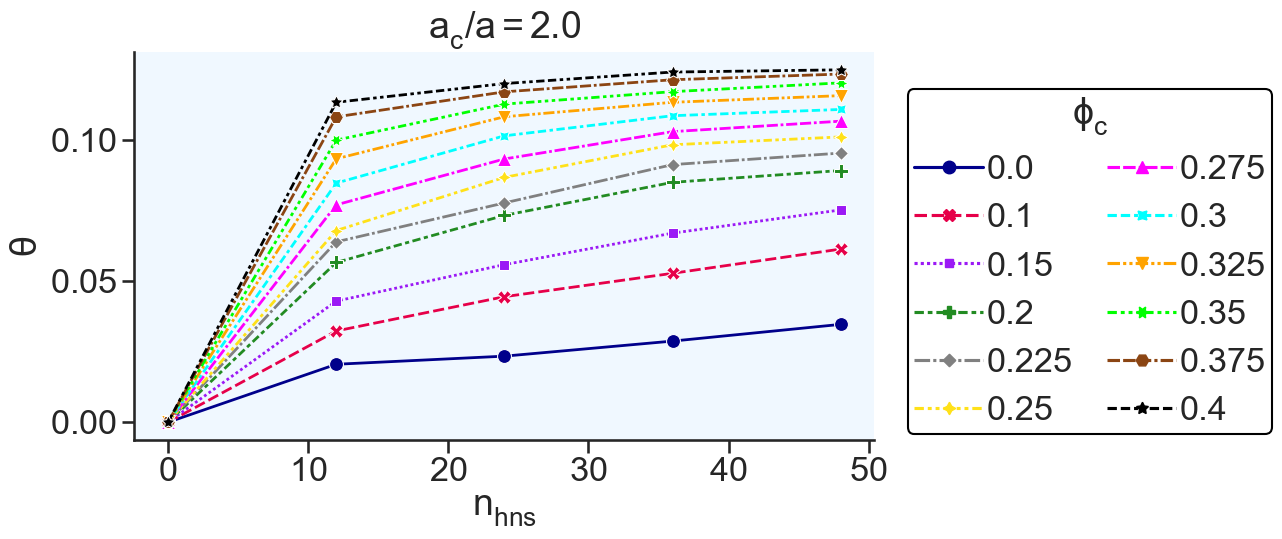

In [33]:
#yname = 'total_bindings_patch'
#yname = 'total_bridging'
yname = 'total_bindings'
ytitles = {
    'total_bridging': 'Bridging probability',
    'total_bindings': r'$\theta$' ,
    'total_bindings_patch': r'$\theta$' 
}
data = all_in_one_equil_props.drop(columns=['ensemble_id','lineage_name', 'whole', 'ensemble_long', 'ensemble', 'space', 'nmon',
       'eps_hm','ncrowd', 'lcube', 'dt', 'ndump', 'adump',
       'dmon', 'mmon', 'dhns', 'mhns', 'mcrowd', 'eps_others',
       'phi_m_bulk', 'rho_m_bulk',  'rho_c_bulk', 'n_frames']).groupby(by=[
       'nhns', 'dcrowd', 'phi_c_bulk'])[f'directContactsMatMonMon-{yname}'].mean().reset_index()
data[f'directContactsMatMonMon-{yname}-norm'] = data[f'directContactsMatMonMon-{yname}'].divide(2*data['nhns']).fillna(0)

from polyphys.manage import utilizer
divisor = 0.025
round_to = 3
data['phi_c_bulk'] = data['phi_c_bulk'].apply(
    utilizer.round_up_nearest, args=[divisor, round_to]
)
## plotting
height = 6
aspect = 1.618 #1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.5
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'stixsans'# 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    'axes.facecolor': 'aliceblue',
}
facet_kws = {
    'sharey': True,
    'sharex': 'row',
    'legend_out': True,
}
legend_kws = {
    'ncol': 2,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}
sns.set_theme(
    context=plot_context,
    style='ticks',
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
data_dcrowd = data.loc[data['dcrowd']==2,:]
f_grid = sns.relplot(
    data=data_dcrowd,
    x='nhns',
    y=f'directContactsMatMonMon-{yname}-norm',
    col='dcrowd',
    hue='phi_c_bulk',
    palette=AC[:len(data['phi_c_bulk'].unique())],
    kind='line',
    markers=True,
    style='phi_c_bulk',
    legend='full',
    height=height,
    aspect=aspect,
    facet_kws=facet_kws,
    lw=2,
    markersize=10
)
f_grid.set_titles(r'$a_c/a={col_name}$')
f_grid.set_xlabels(r'$n_{hns}$')
f_grid.set_ylabels(ytitles[yname])
#f_grid.set_ylabels(r'$\theta$')
f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
sns.move_legend(
    f_grid,
    title=r'$\phi_c$',
    loc='upper left',
    bbox_to_anchor=(0.78,0.83),
    **legend_kws
)
ext = 'pdf'
f_grid.savefig(f'binding_probability-Mon-{yname}-norm.' + ext, bbox_inches='tight', dpi=300
)

In [46]:
merged_melted

,nhns,dcrowd,phi_c_bulk,variable,value
0,0,1.0,0.000,bridging_matrix,0.000000
1,0,2.0,0.000,bridging_matrix,0.000000
2,0,2.0,0.100,bridging_matrix,0.000000
3,0,2.0,0.150,bridging_matrix,0.000000
4,0,2.0,0.200,bridging_matrix,0.000000
...,...,...,...,...,...
125,48,2.0,0.300,contact_matrix,0.111019
126,48,2.0,0.325,contact_matrix,0.115924
127,48,2.0,0.350,contact_matrix,0.120459
128,48,2.0,0.375,contact_matrix,0.123589


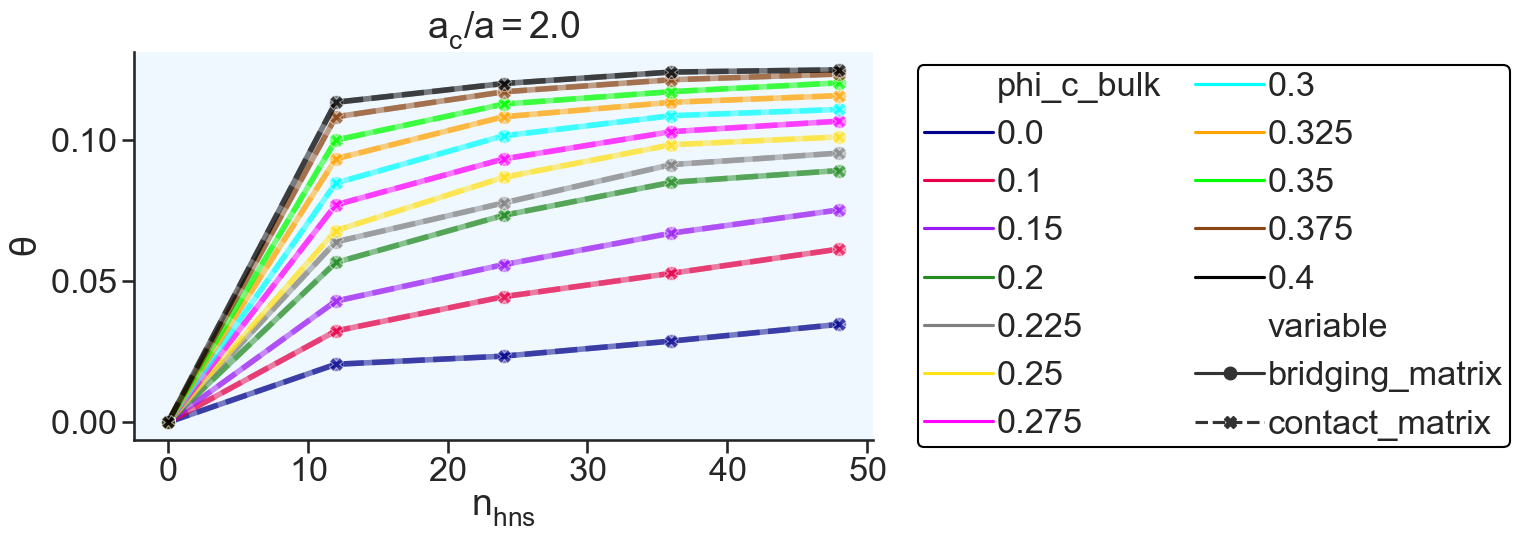

In [62]:
#yname = 'total_bindings_patch'
#yname = 'total_bridging'
yname = 'total_bindings'

## plotting
height = 6
aspect = 1.618 #1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.5
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'stixsans'# 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    'axes.facecolor': 'aliceblue',
}
facet_kws = {
    'sharey': True,
    'sharex': 'row',
    'legend_out': True,
}
legend_kws = {
    'ncol': 2,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}
sns.set_theme(
    context=plot_context,
    style='ticks',
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
merged_melted_dcrowd = merged_melted.loc[merged_melted['dcrowd']==2,:]
f_grid = sns.relplot(
    data=merged_melted_dcrowd,
    x='nhns',
    y='value',
    col='dcrowd',
    hue='phi_c_bulk',
    palette=AC[:len(data['phi_c_bulk'].unique())],
    kind='line',
    markers=True,
    dashes=True,
    style='variable',
    legend='full',
    height=height,
    aspect=aspect,
    facet_kws=facet_kws,
    lw=4,
    alpha=0.5,
    markersize=10
)
f_grid.set_titles(r'$a_c/a={col_name}$')
f_grid.set_xlabels(r'$n_{hns}$')
f_grid.set_ylabels(ytitles[yname])
#f_grid.set_ylabels(r'$\theta$')
f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
sns.move_legend(
    f_grid,
    loc='upper left',
    bbox_to_anchor=(0.7,0.87),
    **legend_kws
)
ext = 'pdf'
f_grid.savefig(f'binding_probability-comparing_approaches.' + ext, bbox_inches='tight', dpi=300
)